In [1]:
from src.HestonModel import generate_heston_paths
import numpy as np
import esig
import matplotlib.pyplot as plt
import iisignature
import signatory
import torch
from tqdm.auto import tqdm

In [2]:
# constant Heston parameters
kappa = 3
theta = 0.02
v_0 = theta #
rho = 0.75
sigma = 0.6
r = 0.04

S = 100
paths = 10000
steps = 50
T = 1

In [3]:
# Get Heston prices and volatilises
prices, sigs = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, sigma, steps, paths, return_vol=True)

In [4]:
prices.shape

(10000, 50)

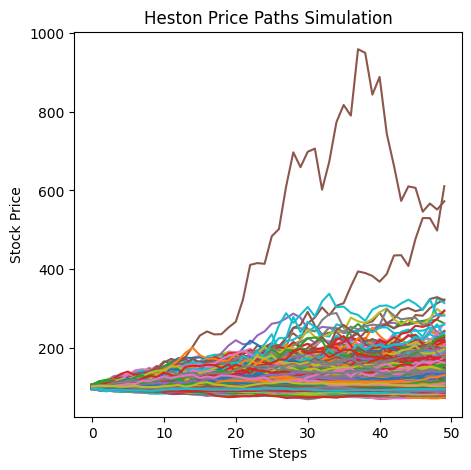

In [5]:
# Plot Heston Price paths
plt.figure(figsize=(5, 5))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()


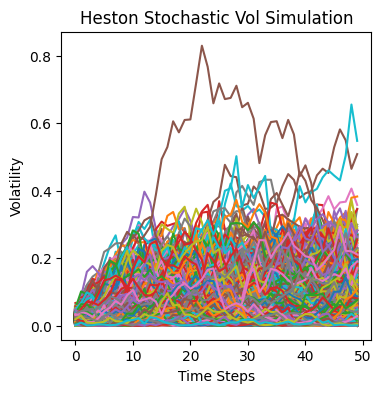

In [6]:
# Plot Heston volatility paths
plt.figure(figsize=(4, 4))
plt.plot(sigs.T)
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.show()

In [7]:
#############################################################################################

In [8]:
thetas=0.15 #Long run variance θ
kappas= np.arange(.5,5.0,0.01) # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.6 #Volatility of variance σ
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [9]:
a=np.random.uniform(.5,5,500)
b=np.arange(.5,5.0,0.01)

In [10]:
depth_of_sig=2  #level of truncation of signatures
width_of_sig=3  # prices + sigmas + time_array (parameters for signatures)
sig_keys = esig.sigkeys(width_of_sig, depth_of_sig)
sig_dim=signatory.signature_channels(width_of_sig,depth_of_sig)

In [11]:
# define time_array and empty tensor for prices and sigmas, signatures and expected signatures
time_array = np.arange(steps)
prices_and_sigs_with_time_tensor = torch.zeros((paths,steps, width_of_sig ))
number_of_loops=kappas.shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape
number_of_loops
prices_and_sigs_with_time_tensor.shape

torch.Size([10000, 100, 3])

In [12]:
def signatures_calculations_kappas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for kappa in kappas:
            # Caclulation of 10000 paths of prices and sigmas
            prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths, return_vol=True)

            for j in range(paths):
                     prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                    #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

            sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
            #     shape of  sign_ps_signatory_differentranges=torch.Size([450, 10000, 12])

            Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
            #     shape of  Exp_sign_signatory_results=torch.Size([450, 12])

            count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [13]:
results_kappas=signatures_calculations_kappas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_kappas=results_kappas[0]
Exp_signatures_results_kappas=results_kappas[1]

In [14]:
Exp_signatures_results_kappas.shape

torch.Size([450, 12])

In [15]:
Exp_signatures_results_kappas

tensor([[3.6725e+00, 2.0800e-02, 9.9000e+01,  ..., 1.8780e+02, 1.0102e+00,
         4.9005e+03],
        [3.5351e+00, 2.0096e-02, 9.9000e+01,  ..., 1.6289e+02, 8.6269e-01,
         4.9005e+03],
        [4.1933e+00, 2.2032e-02, 9.9000e+01,  ..., 2.1939e+02, 1.0346e+00,
         4.9005e+03],
        ...,
        [4.0506e+00, 3.0697e-03, 9.9000e+01,  ..., 1.8978e+02, 4.0788e-02,
         4.9005e+03],
        [4.3559e+00, 2.8484e-03, 9.9000e+01,  ..., 2.1299e+02, 2.5538e-02,
         4.9005e+03],
        [4.0995e+00, 3.3534e-03, 9.9000e+01,  ..., 2.0783e+02, 9.0320e-02,
         4.9005e+03]])

In [16]:
signatures_results_kappas.shape

torch.Size([450, 10000, 12])

In [17]:
signatures_results_kappas[0].shape

torch.Size([10000, 12])

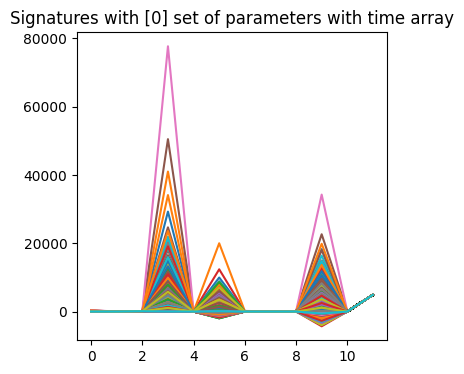

In [18]:
plt.figure(figsize=(4, 4))
plt.plot(signatures_results_kappas[0].T)  #there are 512 sets of parameters
plt.title("Signatures with [0] set of parameters with time array")
plt.show()

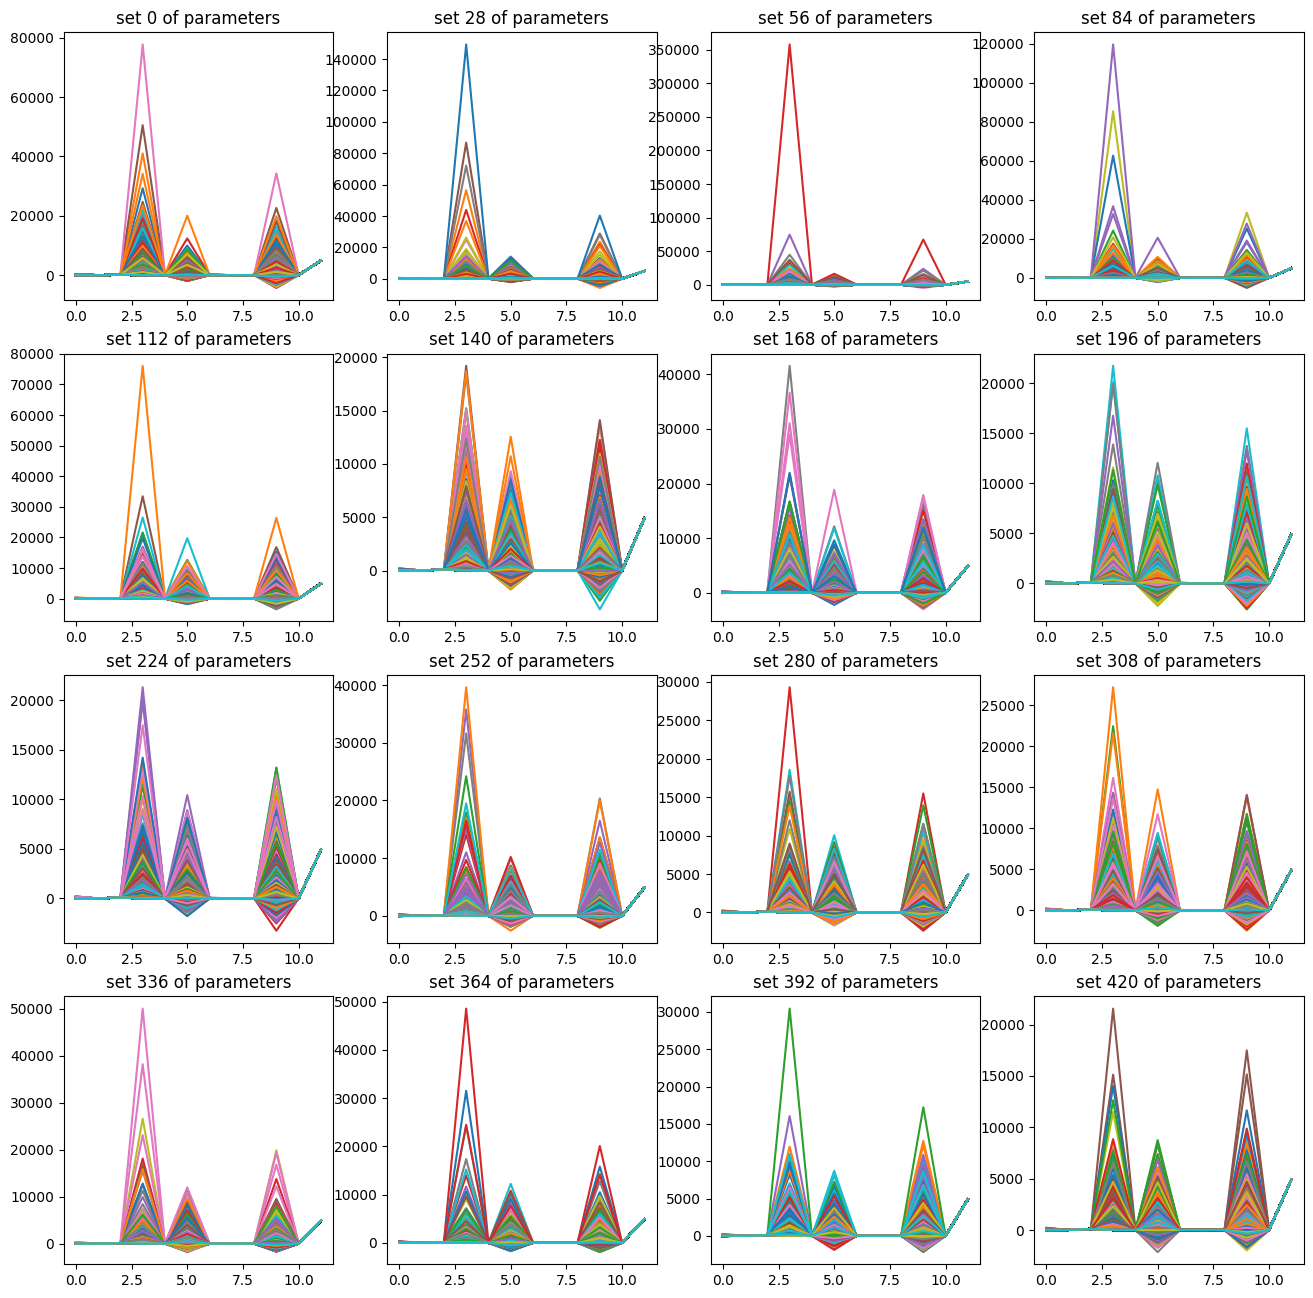

In [19]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text("set " + str(i*28)+" of parameters")
    ax.plot(signatures_results_kappas[i*28].T)
#     Plot 10000 signatures for each set of parameters
#     There are big changes on each plot, which are formed on the signature keys (1,1), (1,3), (3,1)

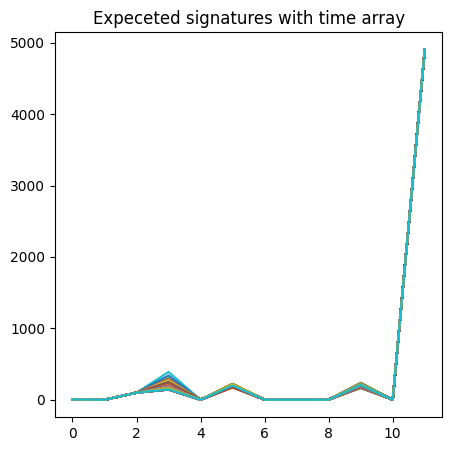

In [20]:
plt.figure(figsize=(5, 5))
plt.plot(Exp_signatures_results_kappas.T[:])
plt.title("Expeceted signatures with time array")
plt.show()
# Plot 512 expected signatures

In [21]:
Exp_signatures_results_kappas.T.shape

torch.Size([12, 450])

In [ ]:
# list([round(x,3) for x in kappas][[1,70,150, 230,300,370,450]])

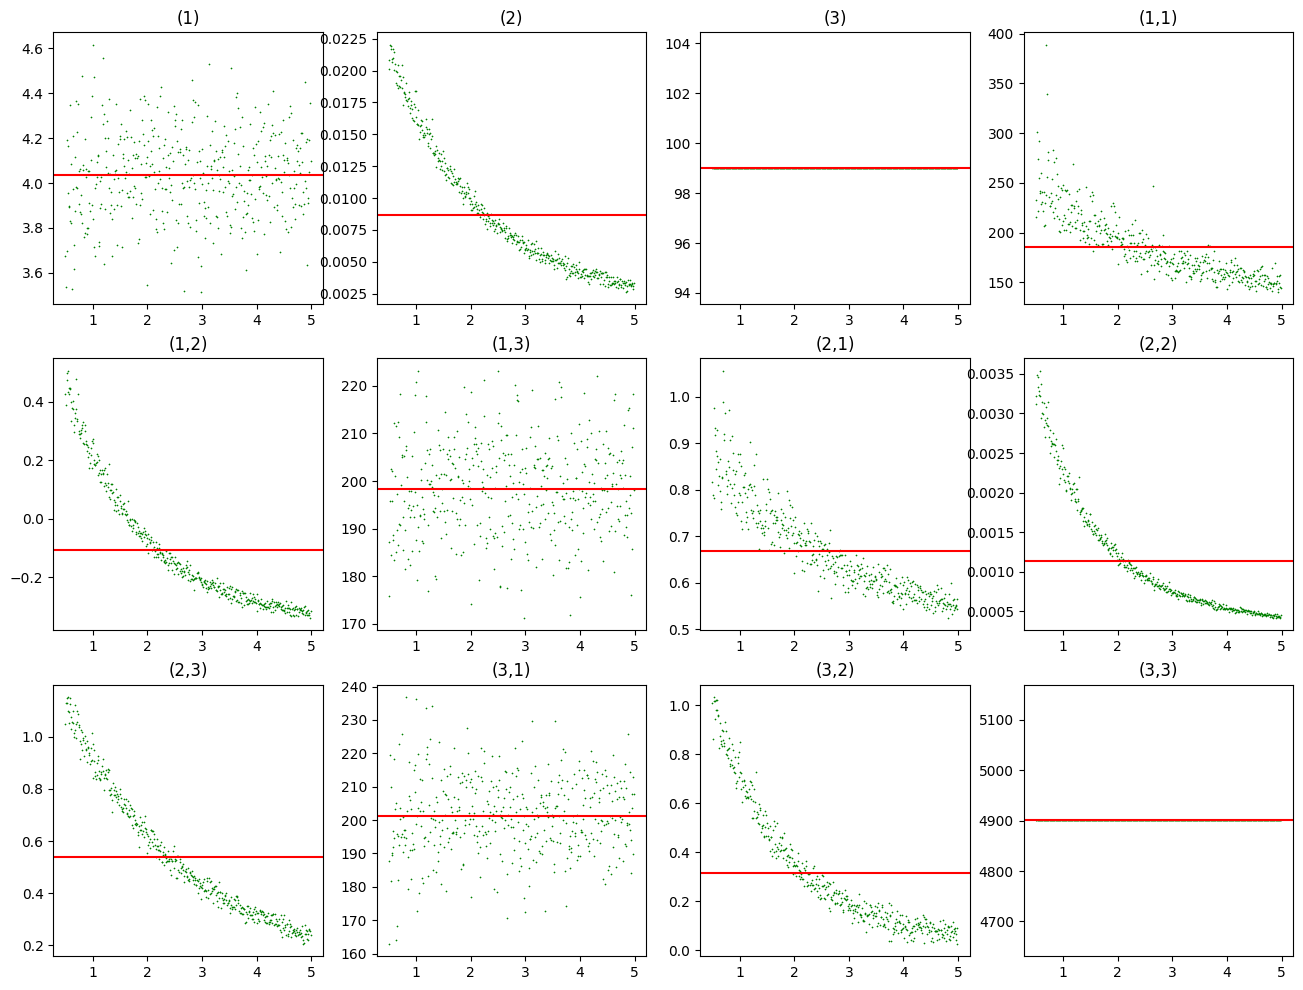

In [25]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(kappas,Exp_signatures_results_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas.T[i]), color='red')



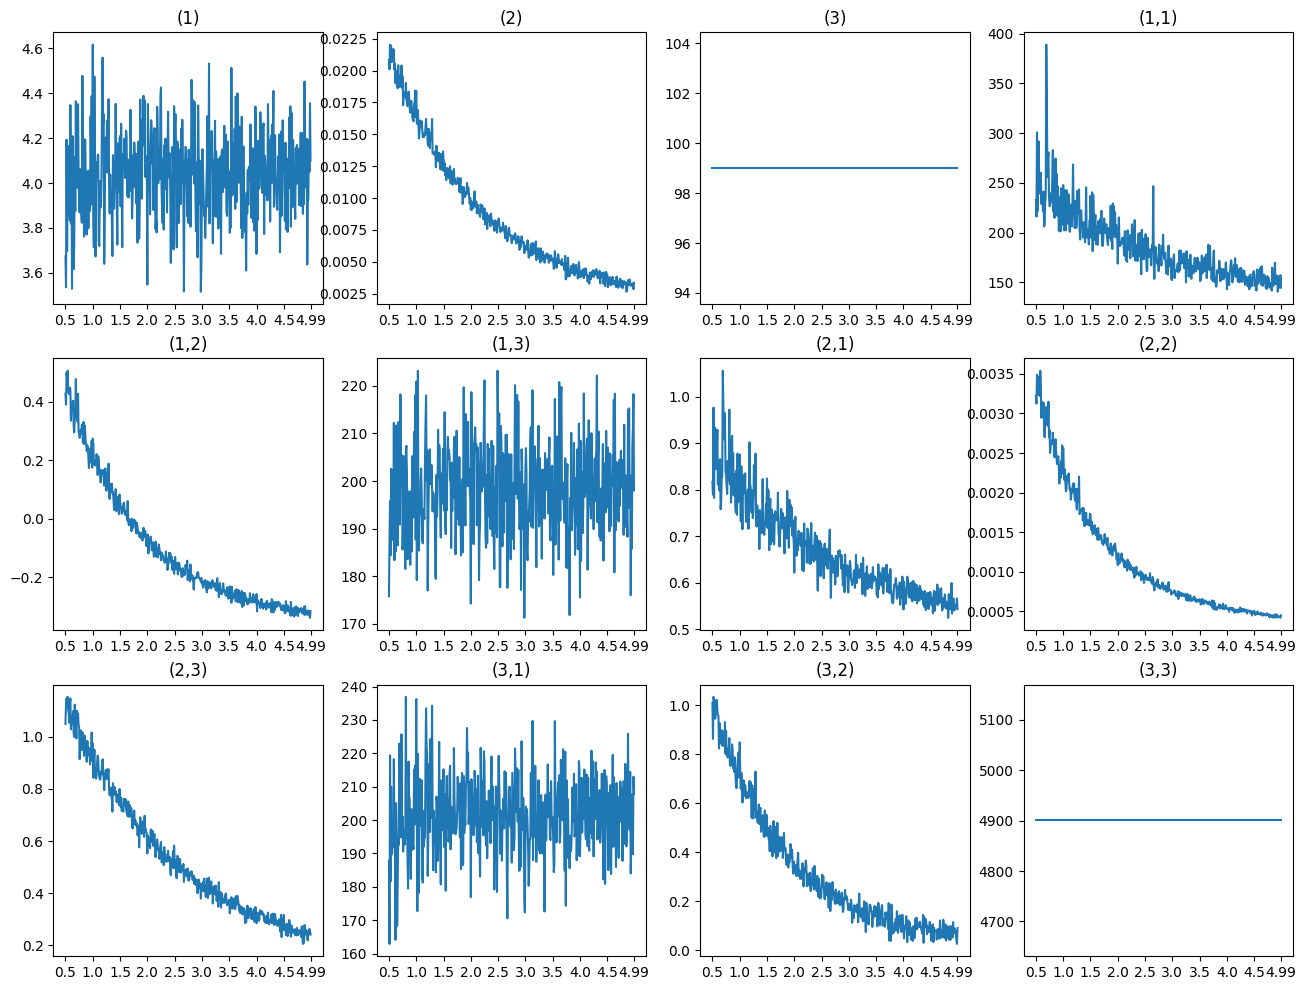

In [23]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_kappas.T[i])
    ax.set_xticks([0,50,100, 150,200,250,300,350,400,449],[round(x,3) for x in list(kappas[[0,50,100, 150,200,250,300,350,400,449]])])

#     For each key of the signature, plot the evolving Expected Signature depending on the kappa's values
#     We can note, that most of the keys of the expected signature depend on kappa's value. Namely, the bigger kappa we have the lower value of the key, especially for         keys that depend on Sigma ( (2), (1,1), (1,2), (2,1), (2,2), (2,3) and (3,2)). although keys (1,1) and (2,1) have a common tendency for the Expected Signature to         decrease as the Kappa-parameter increases, they also have greater volatility.
#     For time keys like (3) and (3,3) we have constant, since it does not change from the parameters
#     However, for the keys (1), (1,3) and (3,1) we cannot say anything in particular, they have a big volatility


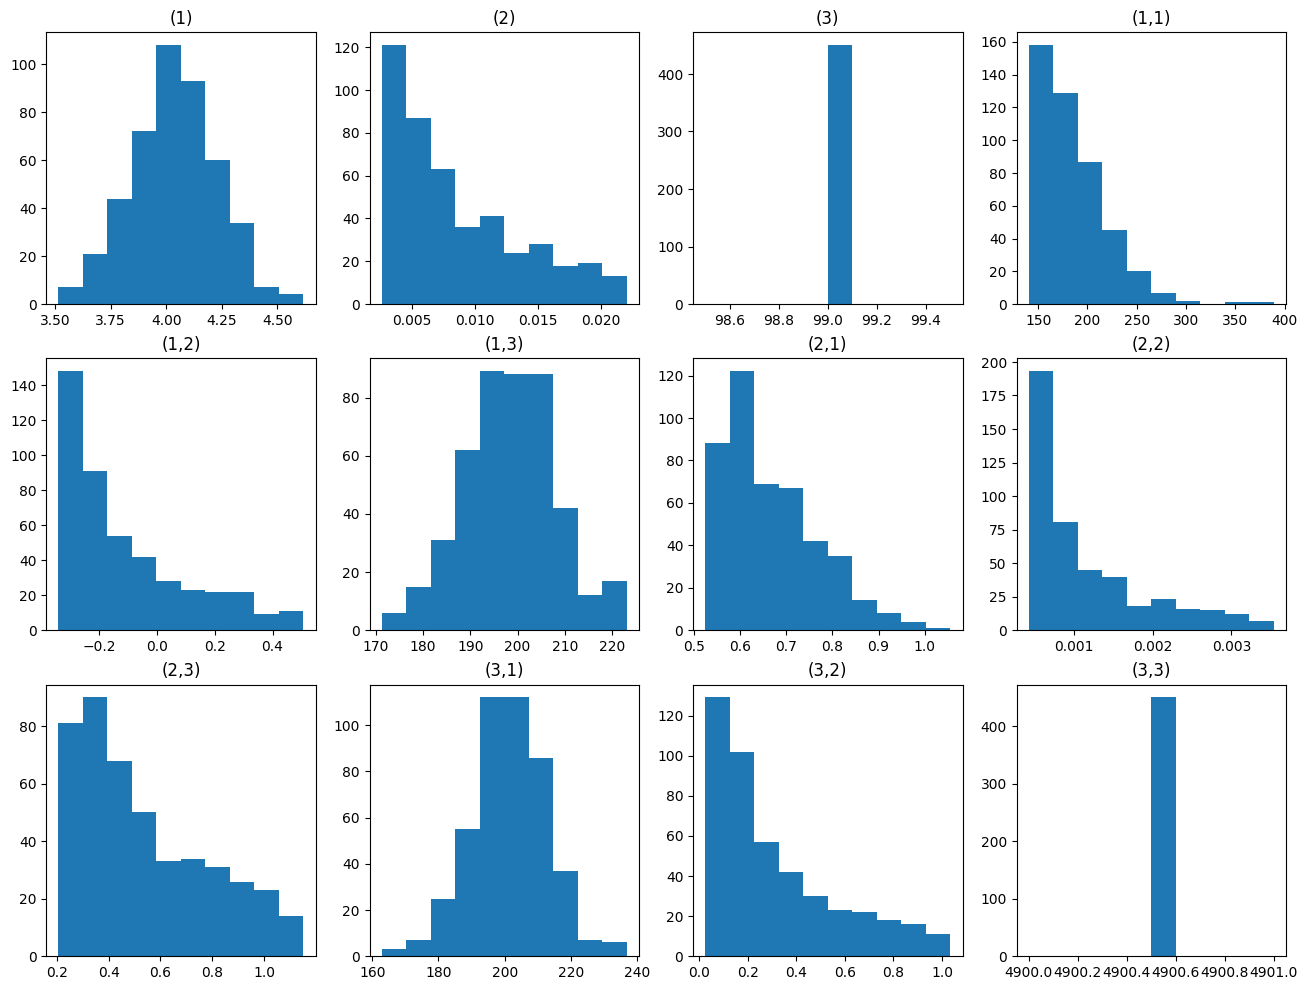

In [24]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.hist(Exp_signatures_results_kappas.T[i])

# Although, if you change the order of parameters in the function "signatures_calculations_with_timearray",
# the graphs of each Expected signature key are different, their histograms are similar.

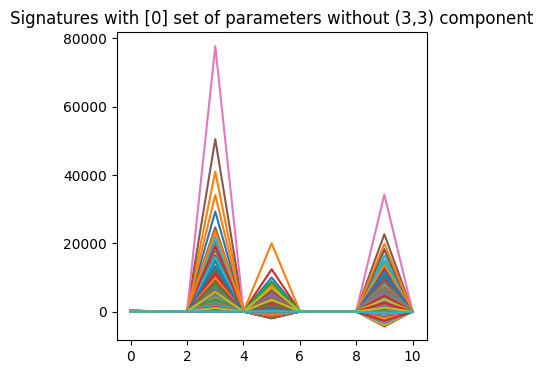

In [26]:
plt.figure(figsize=(4, 4))
plt.plot(signatures_results_kappas[0].T[:-1])  #there are 512 sets of parameters #excluded the last component to better understand the graph, since its value is too big
plt.title("Signatures with [0] set of parameters without (3,3) component")
plt.show()

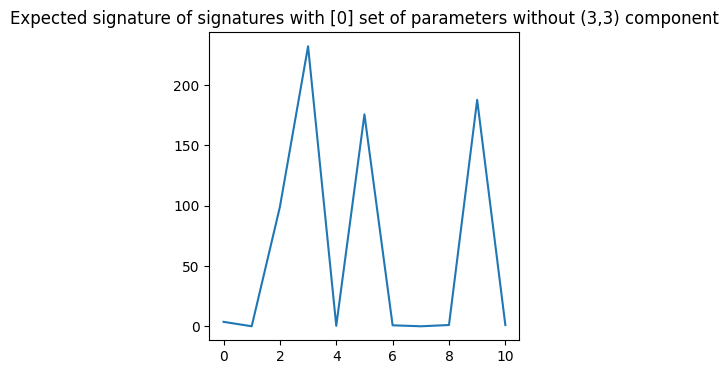

In [27]:
plt.figure(figsize=(4, 4))
plt.plot(Exp_signatures_results_kappas[0].T[:-1])  #there are 512 sets of parameters #exclude last component, since its value is too big
plt.title("Expected signature of signatures with [0] set of parameters without (3,3) component")
plt.show()

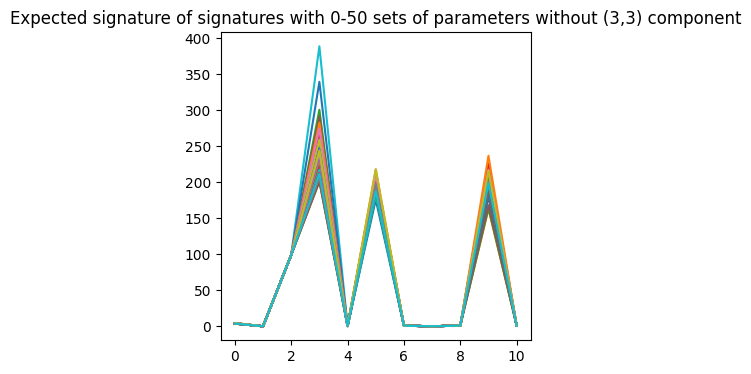

In [28]:
plt.figure(figsize=(4, 4))
plt.plot(Exp_signatures_results_kappas[:50].T[:-1])  #there are 512 sets of parameters #exclude last component, since its value is too big
plt.title("Expected signature of signatures with 0-50 sets of parameters without (3,3) component")
plt.show()

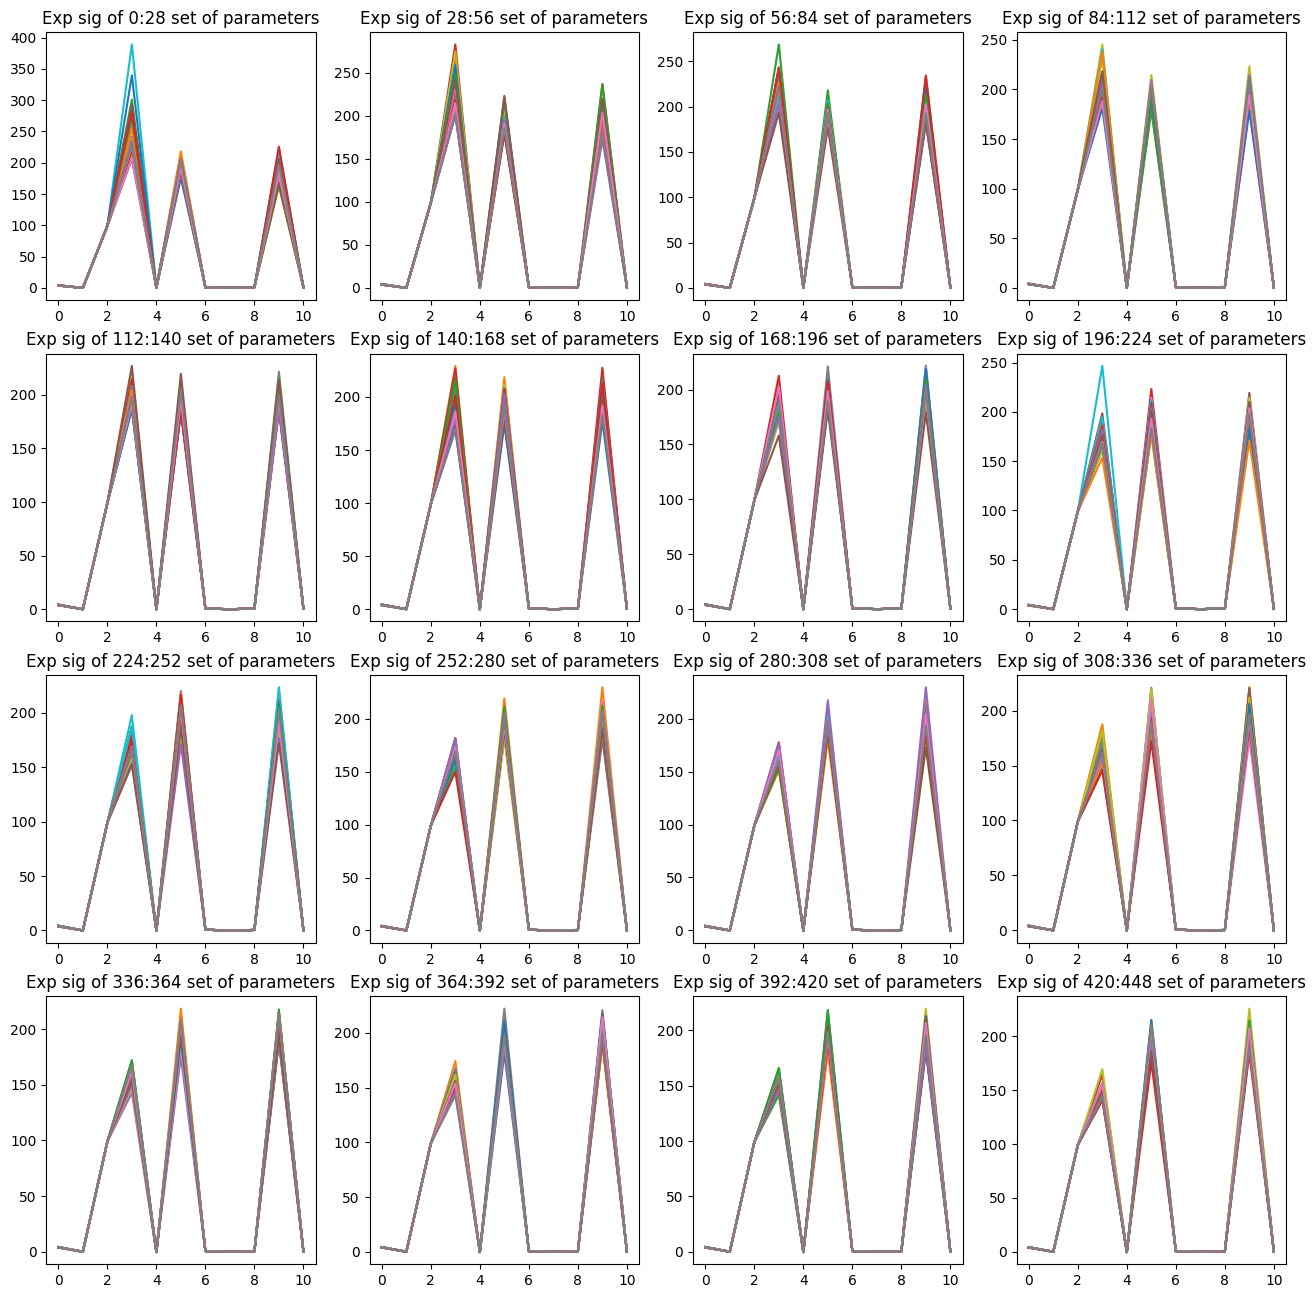

In [29]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text("Exp sig of "  + str(i*28)+":"+ str((i+1)*28)+" set of parameters")
    ax.plot(Exp_signatures_results_kappas[i*28:(i+1)*28].T[:-1]) #for better illustration exclude last component, since its value is too big

In [30]:
# change thetas to 0.01

thetas=0.01 #0.15
kappas= np.arange(.5,5.0,0.01) # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.6 #Volatility of variance σ
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [31]:
results_kappas=signatures_calculations_kappas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_kappas=results_kappas[0]
Exp_signatures_results_kappas=results_kappas[1]

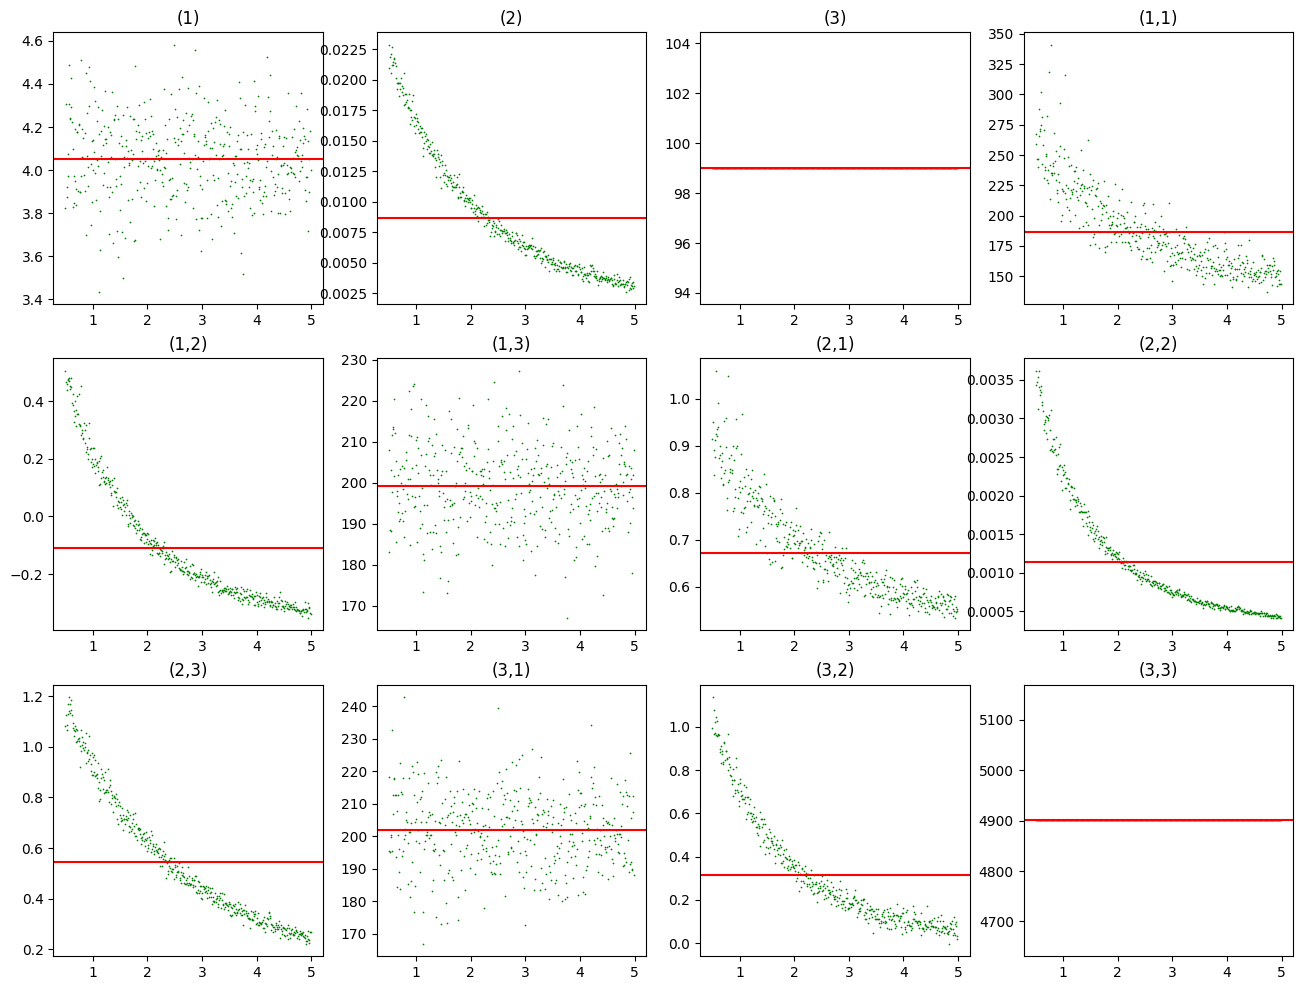

In [33]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(kappas,Exp_signatures_results_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but key (2,3), (3,2) have some bigger values, especially for small thetas
# thus small thetas has no big influence on expected signature components with variable kappas

In [34]:
# change thetas to 1.5

thetas=1.5 #0.15
kappas= np.arange(.5,5.0,0.01) # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.6 #Volatility of variance σ
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [35]:
results_kappas=signatures_calculations_kappas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_kappas=results_kappas[0]
Exp_signatures_results_kappas=results_kappas[1]

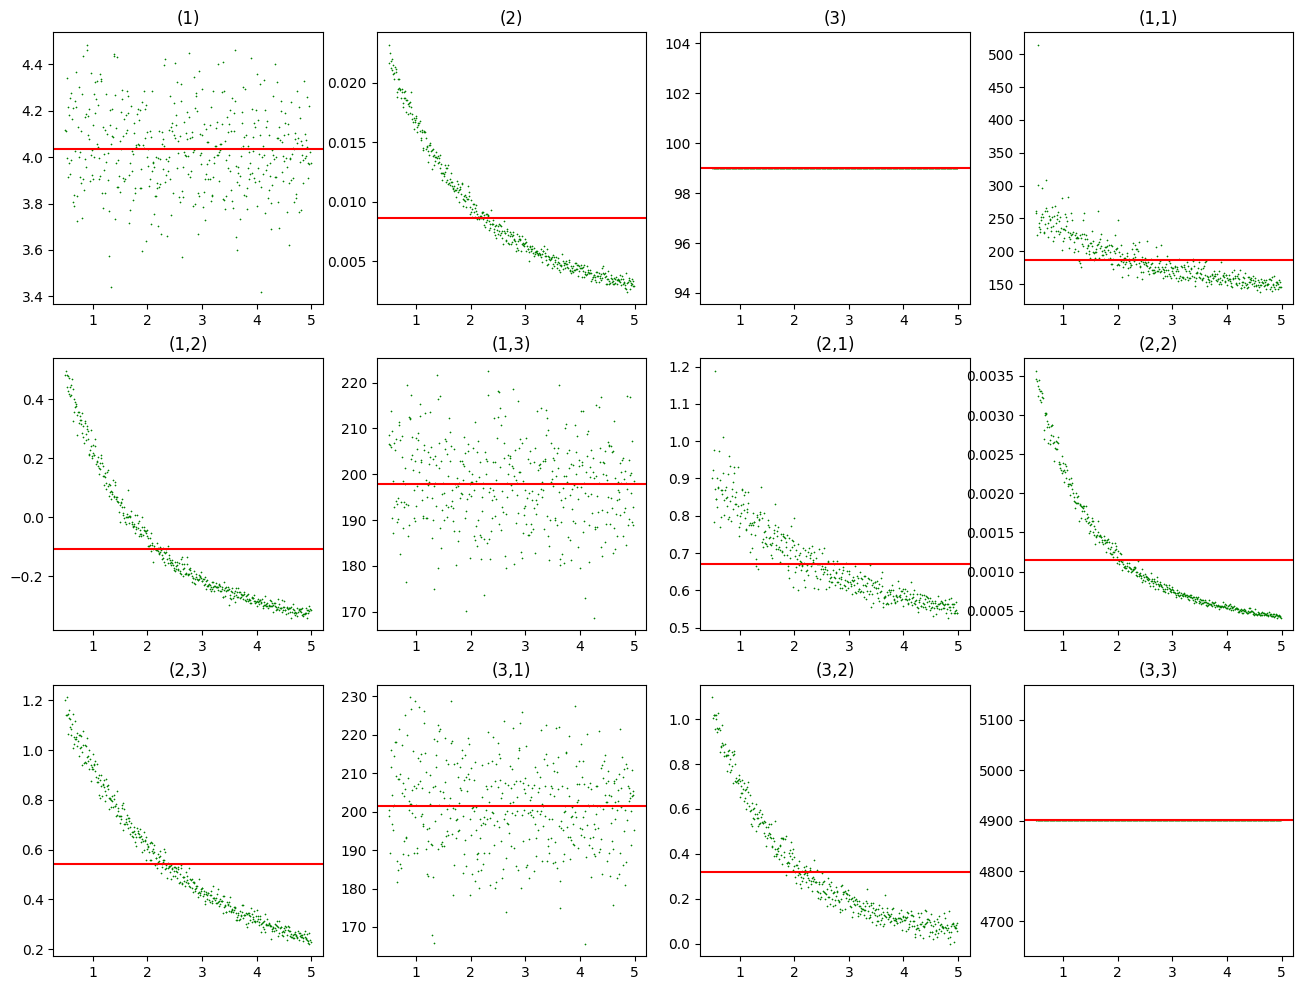

In [36]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(kappas,Exp_signatures_results_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but keys (1,1), (2,3), (2,1) have some outliers that a smaller, especially for small thetas
# thus big thetas has no big influence on expected signature components with variable kappas

In [37]:
# change rhos to 1.5

thetas=0.15 #0.15
kappas= np.arange(.5,5.0,0.01) # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 1.5 #0.6
sigmas = 0.6 #Volatility of variance σ
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [38]:
results_kappas=signatures_calculations_kappas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_kappas=results_kappas[0]
Exp_signatures_results_kappas=results_kappas[1]

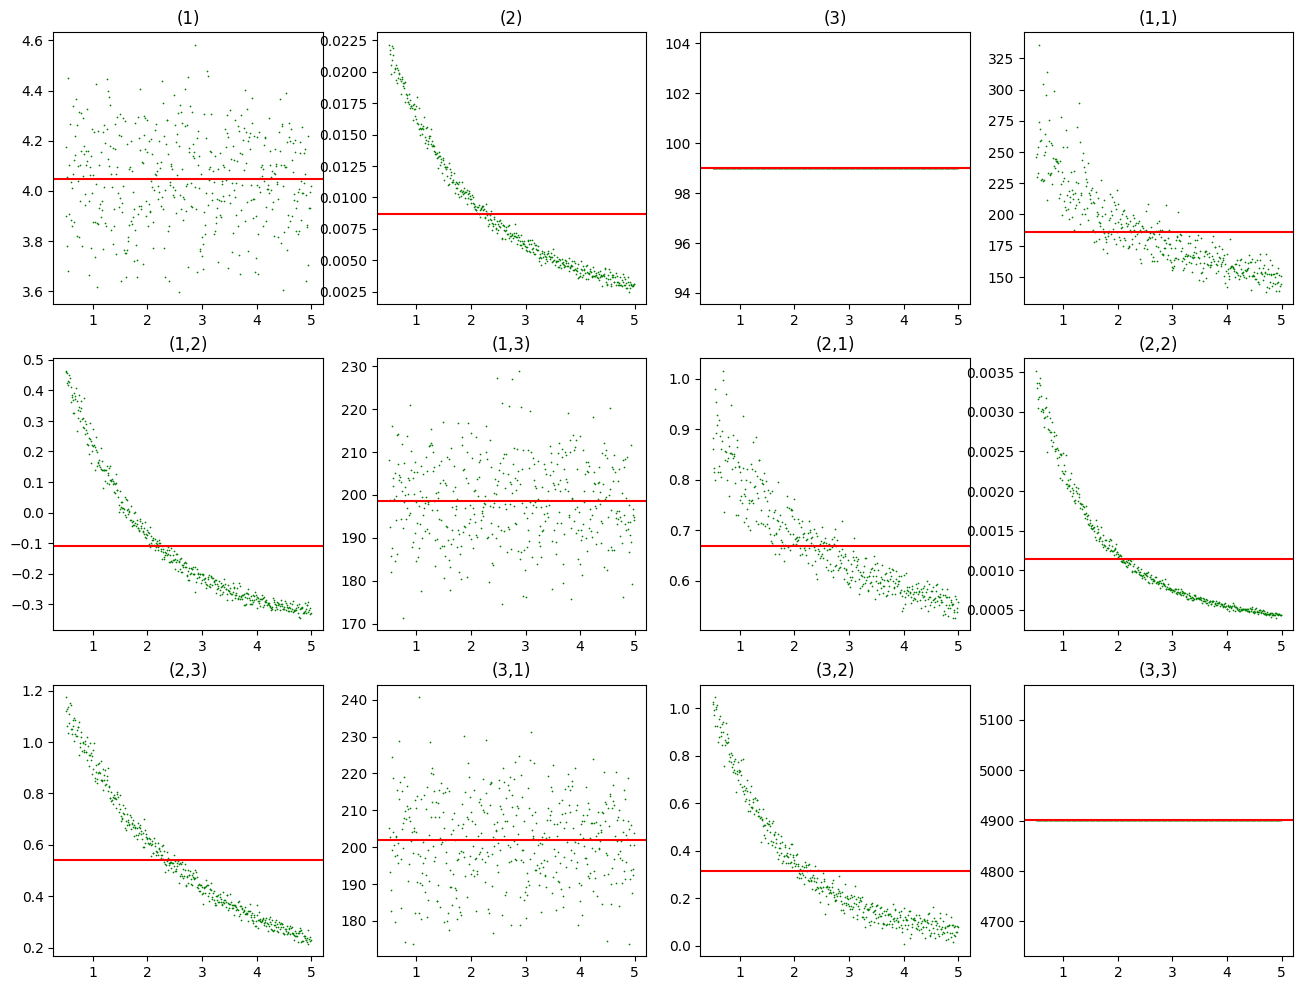

In [39]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(kappas,Exp_signatures_results_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but key (1,1) has lower dispertion
# thus big rhos has no big influence on expected signature components with variable kappas

In [40]:
# change rhos to 0.05

thetas=0.15 #0.15
kappas= np.arange(.5,5.0,0.01) # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.05 #0.6
sigmas = 0.6 #Volatility of variance σ
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [41]:
results_kappas=signatures_calculations_kappas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_kappas=results_kappas[0]
Exp_signatures_results_kappas=results_kappas[1]

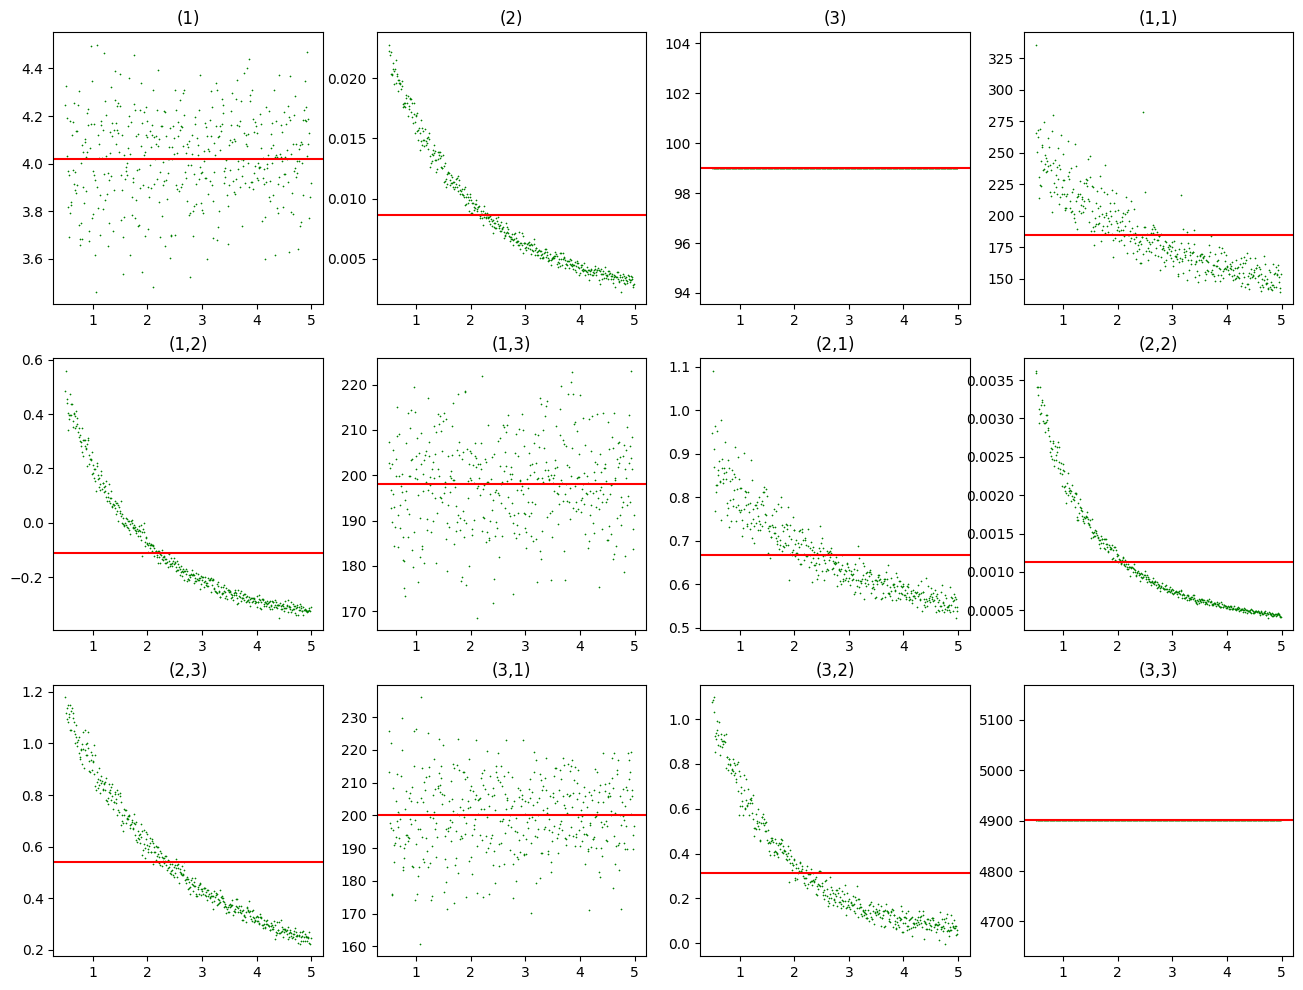

In [42]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(kappas,Exp_signatures_results_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but key (1,1) has lower dispertion
# thus small rhos has no big influence on expected signature components with variable kappas

In [43]:
# change sigmas to 1.5

thetas=0.15 #0.15
kappas= np.arange(.5,5.0,0.01) # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #0.6
sigmas = 1.5 #0.6
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [44]:
results_kappas=signatures_calculations_kappas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_kappas=results_kappas[0]
Exp_signatures_results_kappas=results_kappas[1]

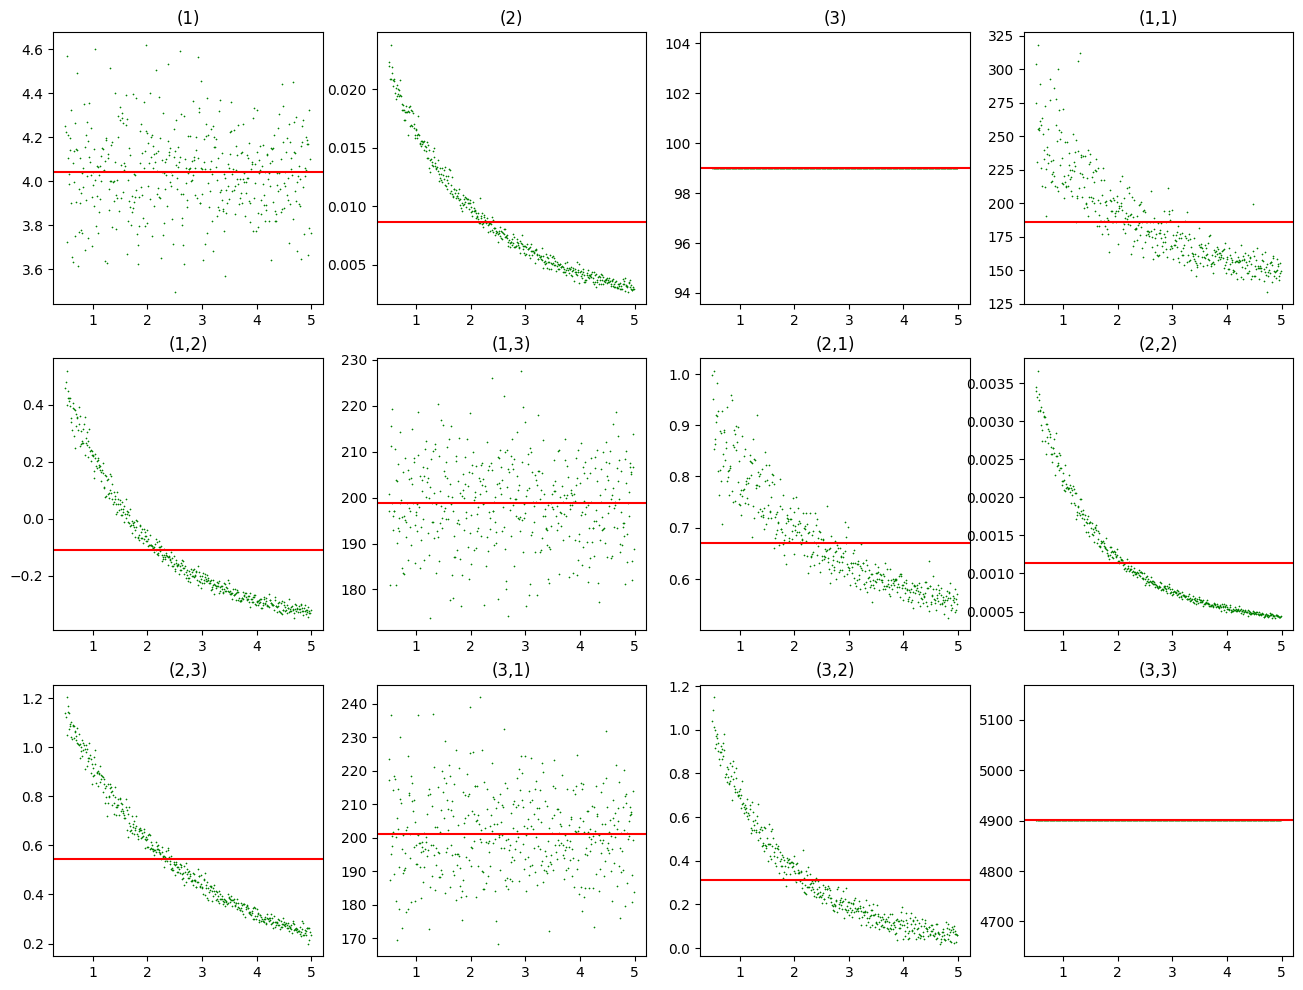

In [45]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(kappas,Exp_signatures_results_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but key (1,1) has less outliers that are smaller, especially for small kappas. Keys (2,3) and (3,2) has bigger values for small kappas
# thus big sigmas has no big influence on expected signature components with variable sigmas

In [49]:
# change sigmas to 0.05

thetas=0.15 #0.15
kappas= np.arange(.5,5.0,0.01) # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #0.6
sigmas = 0.05 #0.6
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [50]:
results_kappas=signatures_calculations_kappas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_kappas=results_kappas[0]
Exp_signatures_results_kappas=results_kappas[1]

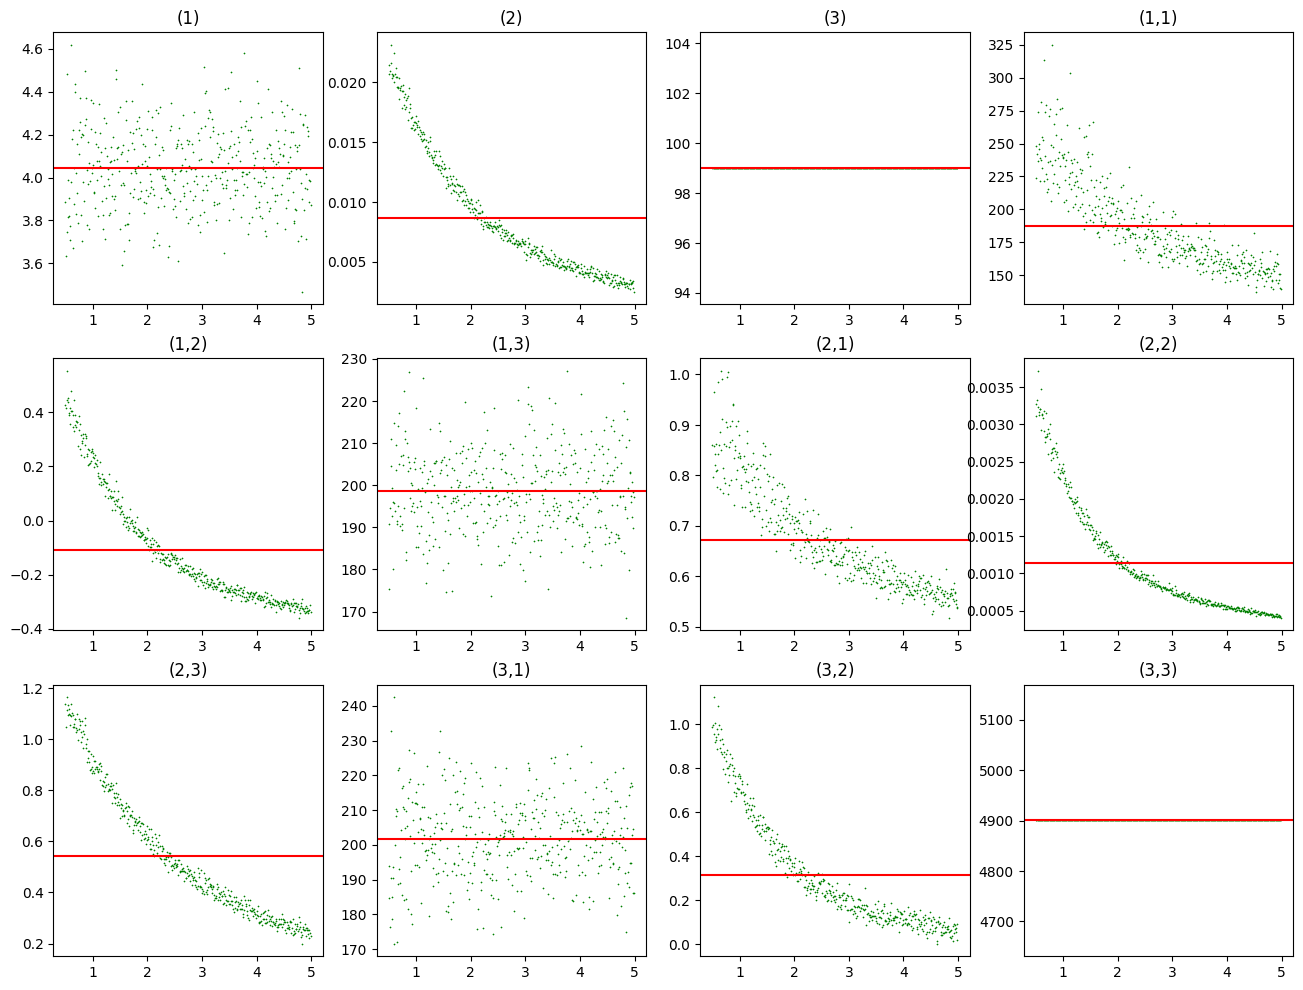

In [51]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(kappas,Exp_signatures_results_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but key (2,3) have some outliers that are bigger, especially for small kappas. Key (1,1) have smaller values for small kappas
# thus small sigmas has no big influence on expected signature components with variable sigmas

In [52]:
# change rs to 0.005

thetas=0.15 #0.15
kappas= np.arange(.5,5.0,0.01) # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #0.6
sigmas = 0.05 #0.6
rs = 0.005 #0.04

S = 100
paths = 10000
steps = 100
T = 1

In [53]:
results_kappas=signatures_calculations_kappas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_kappas=results_kappas[0]
Exp_signatures_results_kappas=results_kappas[1]

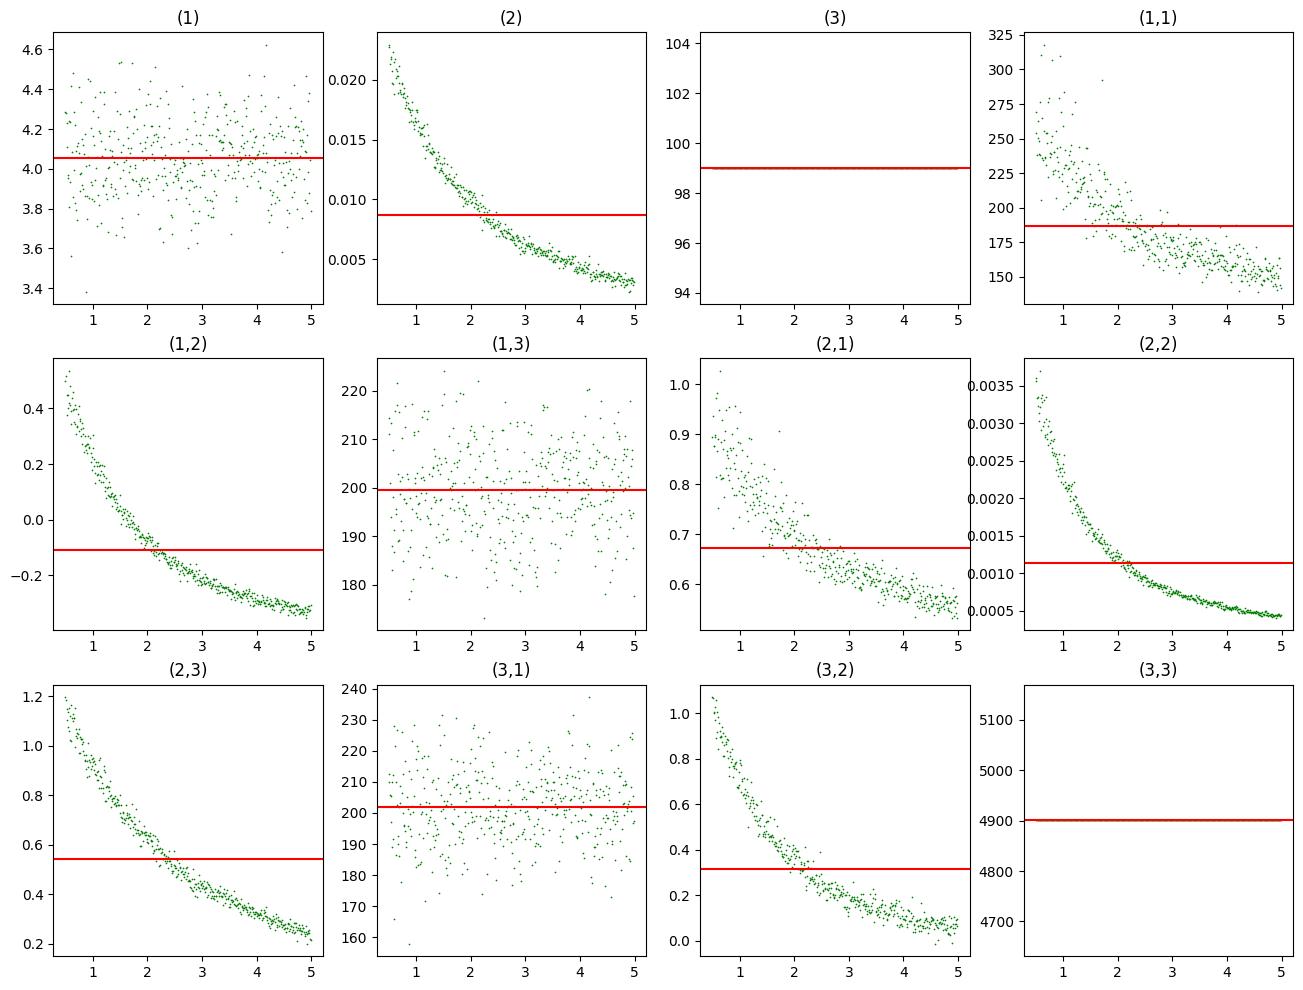

In [54]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(kappas,Exp_signatures_results_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but key (1,1) has smaller outliers, especially for small kappas
# thus small rs has no big influence on expected signature components with variable kappas

In [55]:
# change rs to 0.15

thetas=0.15 #0.15
kappas= np.arange(.5,5.0,0.01) # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #0.6
sigmas = 0.05 #0.6
rs = 0.15 #0.04

S = 100
paths = 10000
steps = 100
T = 1

In [56]:
results_kappas=signatures_calculations_kappas(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_kappas=results_kappas[0]
Exp_signatures_results_kappas=results_kappas[1]

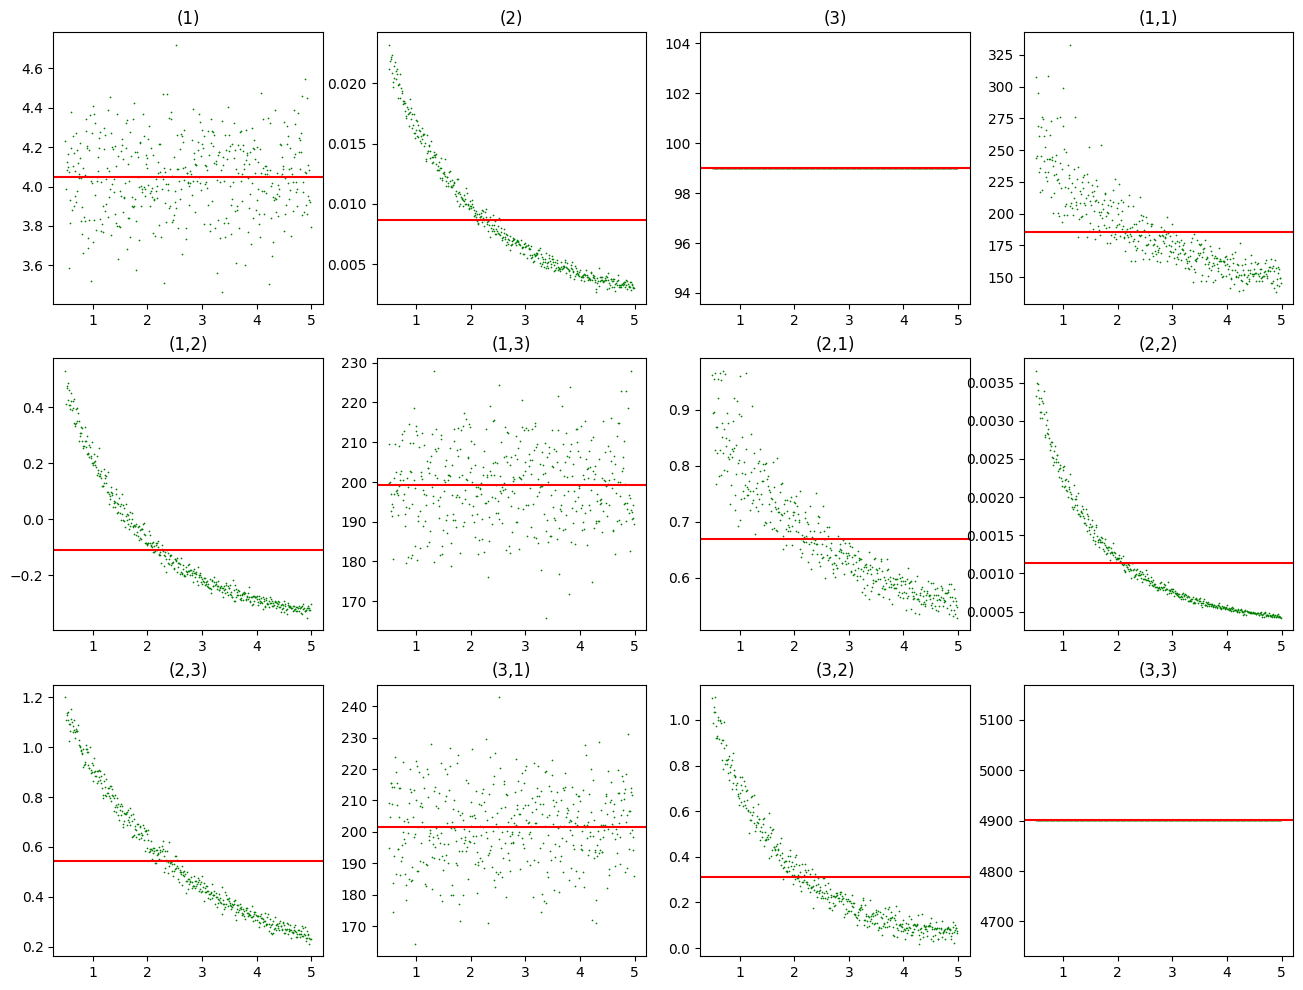

In [57]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(kappas,Exp_signatures_results_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas.T[i]), color='red')

# seems that for most of components we do not have valuable changes, but key (2) have some outliers that a smaller, especially for small thetas
# thus big rs has no big influence on expected signature components with variable kappas